Fetching sequences (may take a few seconds)...
Lengths: BRCA2=11954 bp, BRCA1=7088 bp
Sampling window pairs and computing Smith–Waterman ground truth (this may take time)...
Done sampling.
Train samples: 85, Test samples: 15
Target score mean/std (original): 39.320 / 7.219
Starting training...
Epoch 1/2  train_loss=164555706.6667  train_rmse=12412.9803  test_rmse=12388.0155  test_corr=0.4252
Epoch 2/2  train_loss=128919277.3333  train_rmse=10792.3792  test_rmse=10760.9910  test_corr=0.3851

FINAL TEST METRICS (original score scale):
RMSE (normalized) = 10760.9910
Pearson correlation (normalized) = 0.3851
RMSE (original SW score scale) = 77686.3058


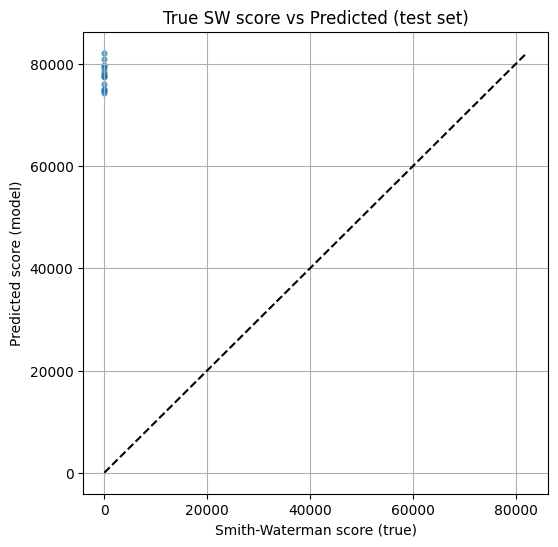


Example true SW score (original scale): 48.000


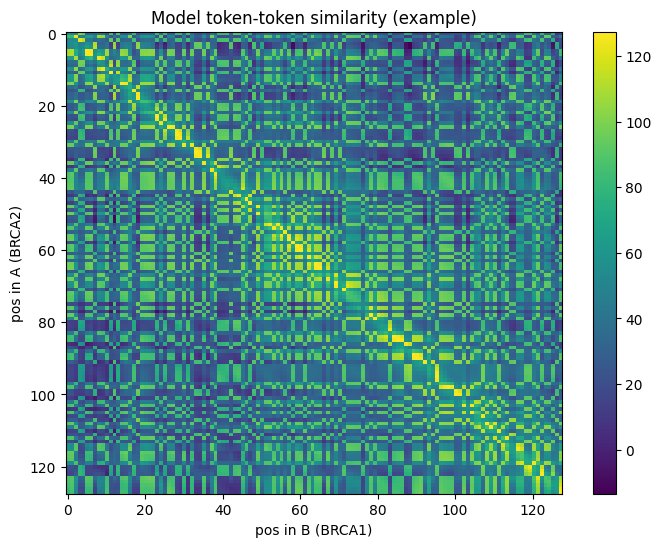


Smith-Waterman alignment (example):
target           34 GTATCAAAAAGTCTATATTCAGAATAAGAGAATCACCTAAAGAG--ACTTTCAATGCAAG
                  0 |||.|..|||.||||-|||----|||.|||.||....||..|||--||....|||.||||
query            12 GTAACTGAAAATCTA-ATT----ATAGGAGCATTTGTTACTGAGCCACAGATAATACAAG

target           92 TTTTTCAGGTCATATGACTGATCCAAACTTTAAAA 127
                 60 ....||...|||.|--|.|.|...|||...|||||  95
query            67 AGCGTCCCCTCACA--AATAAATTAAAGCGTAAAA 100


Script finished.


In [1]:
# smith_transformer_alignment.py
# Requirements: biopython, torch, numpy, matplotlib
# pip install biopython torch matplotlib numpy

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from Bio import Entrez, SeqIO
from Bio.Align import PairwiseAligner
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# 1) SETTINGS / HYPERPARAMS
# ----------------------------
Entrez.email = "example@mail.com"   # set your email for Entrez
ACCESSION_1 = "NM_000059.4"  # BRCA2
ACCESSION_2 = "NM_007294.4"  # BRCA1

WINDOW = 128            # length of windows to compare
NUM_SAMPLES = 100      # total pairs sampled (train+test)
TEST_SPLIT = 0.15
BATCH_SIZE = 32
EMBED_DIM = 64
TRANSFORMER_DIM = 128
NHEAD = 4
NLAYERS = 3
EPOCHS = 2
LR = 1e-4
GAP_PENALTY = -2.0      # used in soft SW
GAMMA = 0.5             # temperature for softmax relaxation (smaller -> sharper)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ----------------------------
# 2) FETCH / LOAD SEQUENCES
# ----------------------------
def fetch_sequence(accession):
    handle = Entrez.efetch(db="nucleotide", id=accession,
                            rettype="fasta", retmode="text")
    seq_record = SeqIO.read(handle, "fasta")
    handle.close()
    return str(seq_record.seq).upper()

print("Fetching sequences (may take a few seconds)...")
seq1 = fetch_sequence(ACCESSION_1)  # BRCA2
seq2 = fetch_sequence(ACCESSION_2)  # BRCA1
print(f"Lengths: BRCA2={len(seq1)} bp, BRCA1={len(seq2)} bp")

# Basic filter to keep only A,C,G,T
def clean_seq(s):
    return "".join([c for c in s if c in "ACGT"])
seq1 = clean_seq(seq1)
seq2 = clean_seq(seq2)

# ----------------------------
# 3) HELPERS: encode, SW label
# ----------------------------
dna_map = {'A':0, 'C':1, 'G':2, 'T':3}

def encode_seq(s):
    return np.array([dna_map[c] for c in s], dtype=np.int64)

enc1 = encode_seq(seq1)
enc2 = encode_seq(seq2)

# Function to compute ground-truth Smith-Waterman score (local alignment) for two strings
aligner = PairwiseAligner()
aligner.mode = "local"
aligner.match_score = 2
aligner.mismatch_score = -1
aligner.open_gap_score = -5
aligner.extend_gap_score = -1

def smith_waterman_score(sA, sB):
    # sA, sB are plain strings of A/C/G/T
    # returns alignment score (float)
    alns = aligner.align(sA, sB)
    if len(alns) == 0:
        return 0.0
    return float(alns[0].score)

# ----------------------------
# 4) CREATE DATASET of window pairs with true SW scores
# ----------------------------
# Strategy:
#  - Sample some positive-ish pairs by sampling windows around high local similarity:
#    but to keep simple we randomly sample pairs and compute the SW score (regression target).
#  - This is slow mainly because SW alignment is computed NUM_SAMPLES times; reduce NUM_SAMPLES for speed.

def sample_window_pairs(encA, encB, window, num_samples):
    X1, X2, y_scores = [], [], []
    la, lb = len(encA), len(encB)
    for _ in range(num_samples):
        i = np.random.randint(0, max(1, la - window + 1))
        j = np.random.randint(0, max(1, lb - window + 1))
        sA = "".join("ACGT"[k] for k in encA[i:i+window])
        sB = "".join("ACGT"[k] for k in encB[j:j+window])
        score = smith_waterman_score(sA, sB)
        X1.append(encA[i:i+window].copy())
        X2.append(encB[j:j+window].copy())
        y_scores.append(score)
    return np.array(X1), np.array(X2), np.array(y_scores, dtype=np.float32)

print("Sampling window pairs and computing Smith–Waterman ground truth (this may take time)...")
X1_all, X2_all, y_all = sample_window_pairs(enc1, enc2, WINDOW, NUM_SAMPLES)
print("Done sampling.")
# Normalize scores (for stability in regression)
y_mean, y_std = y_all.mean(), y_all.std() if y_all.std() > 0 else 1.0
y_norm = (y_all - y_mean) / (y_std + 1e-8)

# Train/test split
indices = np.arange(len(y_norm))
np.random.shuffle(indices)
split = int(len(indices) * (1 - TEST_SPLIT))
train_idx, test_idx = indices[:split], indices[split:]

X1_train, X2_train, y_train = X1_all[train_idx], X2_all[train_idx], y_norm[train_idx]
X1_test, X2_test, y_test = X1_all[test_idx], X2_all[test_idx], y_norm[test_idx]

print(f"Train samples: {len(y_train)}, Test samples: {len(y_test)}")
print(f"Target score mean/std (original): {y_mean:.3f} / {y_std:.3f}")

# ----------------------------
# 5) Pytorch Dataset
# ----------------------------
class WindowPairDataset(Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = torch.from_numpy(X1).long()
        self.X2 = torch.from_numpy(X2).long()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

train_ds = WindowPairDataset(X1_train, X2_train, y_train)
test_ds  = WindowPairDataset(X1_test,  X2_test,  y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# 6) MODEL: Transformer Encoder -> positionwise per-token embeddings
# ----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class TransformerEmbedder(nn.Module):
    def __init__(self, vocab_size=4, embed_dim=EMBED_DIM, d_model=TRANSFORMER_DIM, nhead=NHEAD, num_layers=NLAYERS):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.proj = nn.Linear(embed_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=WINDOW+5)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=4*d_model, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # An optional projection to lower-dim for similarity computations
        self.out_dim = d_model
    def forward(self, x):
        # x: (batch, seq_len) ints
        t = self.token_embed(x)            # (batch, seq_len, embed_dim)
        t = self.proj(t)                   # (batch, seq_len, d_model)
        t = self.pos_enc(t)                # add pos enc
        out = self.transformer(t)          # (batch, seq_len, d_model)
        return out                         # per-position embeddings

# Top-level model: embed both sequences and produce a scalar predicted SW-like score
class SWPredictor(nn.Module):
    def __init__(self, embedder: TransformerEmbedder, gap_penalty=GAP_PENALTY, gamma=GAMMA):
        super().__init__()
        self.embedder = embedder
        self.pool = nn.AdaptiveAvgPool1d(1)  # not used for score, but kept if needed
        self.gap = gap_penalty
        self.gamma = gamma
        # Optionally a small head to rescale the soft-SW score
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.shift = nn.Parameter(torch.tensor(0.0))
    def forward(self, xA, xB):
        # xA, xB: (batch, seq_len)
        embA = self.embedder(xA)   # (batch, L, d)
        embB = self.embedder(xB)   # (batch, L, d)
        # compute similarity matrix S for each batch: dot-product per token
        # S: (batch, L, L)
        S = torch.einsum("bid,bjd->bij", embA, embB)
        # Compute soft Smith-Waterman score for each pair in batch
        scores = soft_smith_waterman_batch(S, gap=self.gap, gamma=self.gamma)  # (batch,)
        # rescale
        return scores * self.scale + self.shift

# ----------------------------
# 7) Differentiable Soft Smith-Waterman (batch)
# ----------------------------
def soft_smith_waterman_batch(S_batch, gap=-2.0, gamma=0.5):
    """
    S_batch: (B, L, L) similarity scores (float)
    returns: (B,) soft local alignment score (scalar) for each sample
    Implements recurrence:
      H[i,j] = logsumexp( (H[i-1,j-1] + S[i-1,j-1])/gamma,
                          (H[i-1,j] + gap)/gamma,
                          (H[i,j-1] + gap)/gamma,
                          0/gamma ) * gamma
    with H[0,*] = H[* ,0] = 0
    The final score is max_{i,j} H[i,j] (we return soft max via logsumexp across all H entries).
    This is differentiable due to logsumexp.
    """
    B, L, _ = S_batch.shape
    device = S_batch.device
    # We'll build H as (B, L+1, L+1)
    H = torch.zeros((B, L+1, L+1), device=device)  # initialized to 0
    # iterate rows
    for i in range(1, L+1):
        # compute for columns j = 1..L
        prev_diag = H[:, i-1, 0:L]      # H[i-1, j-1]
        prev_up   = H[:, i-1, 1:L+1]    # H[i-1, j]
        prev_left = H[:, i, 0:L]        # H[i, j-1]
        # S entries for row i -> S[:, i-1, :]
        s_row = S_batch[:, i-1, :]      # (B, L)
        # Compute three candidates (B, L)
        # note: divide by gamma for tempered logsumexp stability, then multiply after
        cand_diag = (prev_diag + s_row) / gamma
        cand_up   = (prev_up + gap) / gamma
        cand_left = (prev_left + gap) / gamma
        zero = torch.zeros_like(cand_diag)
        stacked = torch.stack([cand_diag, cand_up, cand_left, zero], dim=-1)  # (B, L, 4)
        # logsumexp over last dim
        new_vals = torch.logsumexp(stacked, dim=-1) * gamma  # (B, L)
        H[:, i, 1:L+1] = new_vals
    # Now H contains scores; true local alignment score is max_{i,j} H[i,j]
    # We return a differentiable soft-max over the H entries: logsumexp / 1 (since we want a soft global max).
    H_flat = H[:, 1:, 1:].reshape(B, -1)  # ignore zero row/col
    # Optional: to make output scale comparable to SW scores, we can take gamma * logsumexp(H/gamma) - but here H is in same units
    # soft_max = gamma * torch.logsumexp(H_flat / gamma, dim=1)
    # Simpler: use max via logsumexp with temperature as soft approximation:
    soft_max = torch.logsumexp(H_flat / gamma, dim=1) * gamma
    # To be a bit more stable numerically, subtract max(H) before logsumexp? PyTorch handles it
    return soft_max  # (B,)

# ----------------------------
# 8) TRAINING
# ----------------------------
model = SWPredictor(TransformerEmbedder(), gap_penalty=GAP_PENALTY, gamma=GAMMA).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

def evaluate(loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for a, b, y in loader:
            a = a.to(DEVICE); b = b.to(DEVICE)
            out = model(a, b)
            preds.append(out.detach().cpu().numpy())
            trues.append(y.numpy())
    preds = np.concatenate(preds).ravel()
    trues = np.concatenate(trues).ravel()
    mse = np.mean((preds - trues)**2)
    rmse = math.sqrt(mse)
    # compute Pearson corr
    if np.std(preds) > 0 and np.std(trues) > 0:
        corr = np.corrcoef(preds, trues)[0,1]
    else:
        corr = 0.0
    return rmse, corr, preds, trues

print("Starting training...")
for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_losses = []
    for a, b, y in train_loader:
        a = a.to(DEVICE); b = b.to(DEVICE); y = y.to(DEVICE)
        optimizer.zero_grad()
        out = model(a, b).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    rmse_train, corr_train, _, _ = evaluate(train_loader)
    rmse_test, corr_test, _, _ = evaluate(test_loader)
    print(f"Epoch {epoch}/{EPOCHS}  train_loss={np.mean(epoch_losses):.4f}  train_rmse={rmse_train:.4f}  test_rmse={rmse_test:.4f}  test_corr={corr_test:.4f}")

# ----------------------------
# 9) EVALUATION & VISUALIZATION
# ----------------------------
rmse_test, corr_test, preds_test, trues_test = evaluate(test_loader)
# un-normalize for display (optional)
preds_un = preds_test * (y_std + 1e-8) + y_mean
trues_un = trues_test * (y_std + 1e-8) + y_mean

print("\nFINAL TEST METRICS (original score scale):")
print(f"RMSE (normalized) = {rmse_test:.4f}")
print(f"Pearson correlation (normalized) = {corr_test:.4f}")
# compute RMSE on original scale
rmse_orig = math.sqrt(np.mean((preds_un - trues_un)**2))
print(f"RMSE (original SW score scale) = {rmse_orig:.4f}")

# Scatter plot: true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(trues_un, preds_un, s=12, alpha=0.6)
mn = min(trues_un.min(), preds_un.min())
mx = max(trues_un.max(), preds_un.max())
plt.plot([mn,mx], [mn,mx], 'k--')
plt.xlabel("Smith-Waterman score (true)")
plt.ylabel("Predicted score (model)")
plt.title("True SW score vs Predicted (test set)")
plt.grid(True)
plt.show()

# Visualize one example: similarity matrix + SW alignment
# pick a test sample with high true score to inspect
idx = np.argmax(trues_un)  # index in test arrays
# find the corresponding original test pair (we need indices map)
# we'll just re-create one high-scoring pair by scanning a small batch: simpler approach:
# Recompute SW and similarity for one example from the test arrays
example_idx = test_idx[idx]  # index in original sampled arrays
exA = X1_all[example_idx]  # encoded
exB = X2_all[example_idx]
sA = "".join("ACGT"[k] for k in exA)
sB = "".join("ACGT"[k] for k in exB)
true_score = smith_waterman_score(sA, sB)
print(f"\nExample true SW score (original scale): {true_score:.3f}")

# compute model similarity matrix for that pair
model.eval()
with torch.no_grad():
    a_t = torch.from_numpy(exA).unsqueeze(0).long().to(DEVICE)
    b_t = torch.from_numpy(exB).unsqueeze(0).long().to(DEVICE)
    embA = model.embedder(a_t)[0].cpu().numpy()   # (L, d)
    embB = model.embedder(b_t)[0].cpu().numpy()   # (L, d)
    S = embA @ embB.T   # (L, L) similarity matrix

plt.figure(figsize=(8,6))
plt.imshow(S, aspect='auto')
plt.colorbar()
plt.title("Model token-token similarity (example)")
plt.xlabel("pos in B (BRCA1)")
plt.ylabel("pos in A (BRCA2)")
plt.show()

# print Smith-Waterman alignment for the example
alignment = aligner.align(sA, sB)[0]
print("\nSmith-Waterman alignment (example):")
print(alignment)

# Done
print("\nScript finished.")